# Character-level sequence to sequence modeling for Spanish -> English translation 

In practice, you would use word-level modeling for machine translation, here we use character-level modeling for time
( and in practice you also use deep LSTMs; also, it may be helpful to use a BiLSTM as the encoder): you can try all these changes
    
Based on https://gist.github.com/kiwenlau/4e204587e715d95ad567ba0c37b9fa03

# Summary of the algorithm

- Train an LSTM encoder on the input language (Spanish) that returns the 2 state vectors
- Train an LSTM decoder to take the state vectors from the input sentence and generate the output sentence. Use teacher forcing here

- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax; in general use beam search).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.

## References

- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
    
## Data download

Spanish to English sentence pairs.
http://www.manythings.org/anki/spa-eng.zip

Lots of neat sentence pairs datasets can be found at:
http://www.manythings.org/anki/

In [34]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

batch_size = 64  
epochs = 100 
encoding_dim = 256  
numtrain = 10000 
data_path = 'spa-eng/spa.txt'

In [35]:
# Read in training data and generate the input and output vocabularies (unique characters )
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')

for line in lines[: min(numtrain, len(lines) - 1)]:
    target_text, input_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

# We will align the inputs and outputs to the maximum sequence lengths of the inputs and outputs

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 82
Number of unique output tokens: 71
Max sequence length for inputs: 40
Max sequence length for outputs: 18


In [30]:
# Tokenize and encode the training data

# Construct a look-up table (dictionary) for converting the characters to their indices in the dictionaries
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# Use one-hot encoding (since the vocabulary is small, this is fine; we could use an embedding layer as before, and would if we were dealing with word-level modeling)
# so each training example is a sequence of maxinputsequencelength vectors of size num_encoder_tokens
# this means the size of the input data is (numtrain, maxinputsequencelength, num_encoder_tokens) and similarly for the output
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# Note that we are aligning the inputs and outputs by adding zeros to the end (not the start as before)
# Since we use teacher forcing, the training input sequence for the decoder is '\t' followed by the true target sequence, and the 
# training output sequence is the input sequence, since we try to predict the next character conditioned on all the characters seen before

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [32]:
# Define the encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(encoding_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# We discard `encoder_outputs` and only keep the states, to use to drive the decoder
encoder_states = [state_h, state_c]

# Define the decoder, using `encoder_states` as initial state.  The decoder returns the full
# output sequence, because we need them at inference time; we don't use these during training
# because we do teacher forcing.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(encoding_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the overall encoder decoder model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
encoder_decoder_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
encoder_decoder_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = encoder_decoder_model.fit(
          [encoder_input_data, decoder_input_data], 
          decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
encoder_decoder_model.save("s2e")

Epoch 1/100
125/125 [==============================] - 8s 68ms/step - loss: 2.1733 - acc: 0.1871 - val_loss: 2.3980 - val_acc: 0.2901
Epoch 2/100
125/125 [==============================] - 8s 67ms/step - loss: 1.8260 - acc: 0.2769 - val_loss: 2.0249 - val_acc: 0.3754
Epoch 3/100
125/125 [==============================] - 9s 69ms/step - loss: 1.5604 - acc: 0.3237 - val_loss: 1.9047 - val_acc: 0.3862
Epoch 4/100
125/125 [==============================] - 8s 65ms/step - loss: 1.4465 - acc: 0.3482 - val_loss: 1.8944 - val_acc: 0.3870
Epoch 5/100
125/125 [==============================] - 8s 67ms/step - loss: 1.3666 - acc: 0.3682 - val_loss: 1.8409 - val_acc: 0.4119
Epoch 6/100
125/125 [==============================] - 9s 70ms/step - loss: 1.3014 - acc: 0.3858 - val_loss: 1.6577 - val_acc: 0.4543
Epoch 7/100
125/125 [==============================] - 9s 71ms/step - loss: 1.2502 - acc: 0.4006 - val_loss: 1.6641 - val_acc: 0.4518
Epoch 8/100
125/125 [==============================] - 9s 68ms

INFO:tensorflow:Assets written to: s2e/assets


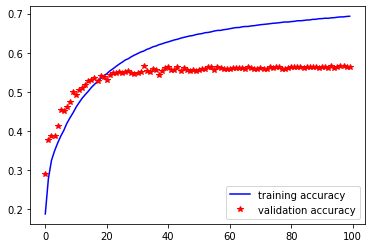

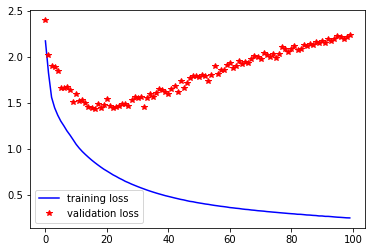

In [40]:
plt.plot(range(epochs), history.history['acc'], 'b-', label="training accuracy")
plt.plot(range(epochs), history.history['val_acc'], 'r*', label="validation accuracy")
plt.legend()
plt.show()

plt.plot(range(epochs), history.history['loss'], 'b-', label="training loss")
plt.plot(range(epochs), history.history['val_loss'], 'r*', label="validation loss")
plt.legend()
plt.show()

In [41]:
# Inference mode (sampling).
# To translate an input:
# 1) encode input and retrieve final encoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as input.
# Output will be the next target token
# 3) Repeatedly use the current output as input to the RNN 
#   to output the next target token; stop when generate '\n'
#  or output sequence is too long

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(encoding_dim,))
decoder_state_input_c = Input(shape=(encoding_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup table to decode sequences back to
# something readable, after the softmax
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Input target sequence consisting just of start character to the decoder.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [42]:
# Try encoding and decoding on some training data

for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Ve.
Decoded sentence: I saw one.

-
Input sentence: Vete.
Decoded sentence: I saw that.

-
Input sentence: Vaya.
Decoded sentence: Go now.

-
Input sentence: Váyase.
Decoded sentence: Let's go down.

-
Input sentence: Hola.
Decoded sentence: Hello!

-
Input sentence: ¡Corre!
Decoded sentence: Run!

-
Input sentence: ¡Corran!
Decoded sentence: Run!

-
Input sentence: ¡Corra!
Decoded sentence: Run!

-
Input sentence: ¡Corred!
Decoded sentence: Run!

-
Input sentence: Corred.
Decoded sentence: I know Tom.

-
Input sentence: ¿Quién?
Decoded sentence: Who wants tea?

-
Input sentence: ¡Órale!
Decoded sentence: Come on in!

-
Input sentence: ¡Fuego!
Decoded sentence: Shoot!

-
Input sentence: ¡Incendio!
Decoded sentence: Shoot!

-
Input sentence: ¡Disparad!
Decoded sentence: Shoot!

-
Input sentence: ¡Ayuda!
Decoded sentence: Help!

-
Input sentence: ¡Socorro! ¡Auxilio!
Decoded sentence: Face facts!

-
Input sentence: ¡Auxilio!
Decoded sentence: Seize him!

-
Input sentence